I = 0.6480000000000001
K_eq = 24.063200000000002
delta = 0.02700617283950617
omega_d = 6.093754061977159

=== Ошибки угла theta(t) ===
Forward Euler:  max = 5.542447287267883 , L2 = 6.18824922952981
Backward Euler: max = 0.8988698130600802 , L2 = 1.556276827926391
RK4:            max = 7.218891634477864e-06 , L2 = 1.0293136668923026e-05

=== Ошибки скорости theta_dot(t) ===
Forward Euler:  max = 32.36878676680614 , L2 = 36.83827293602283
Backward Euler: max = 5.462057553323839 , L2 = 9.414637917712273
RK4:            max = 4.487957085116956e-05 , L2 = 6.352626800247452e-05


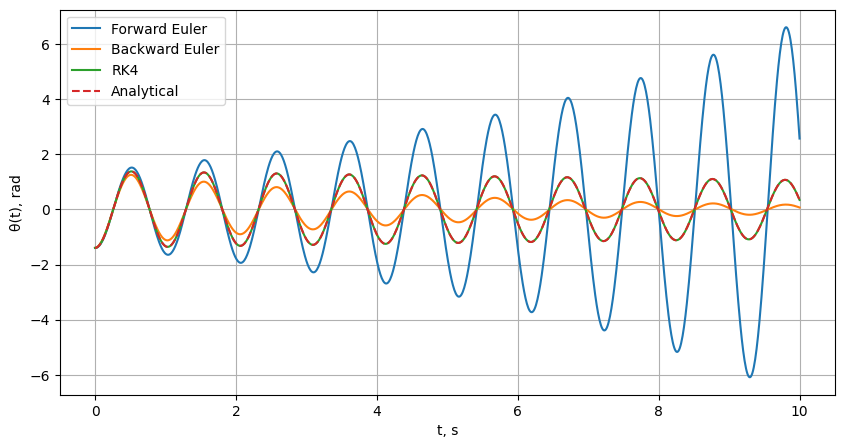

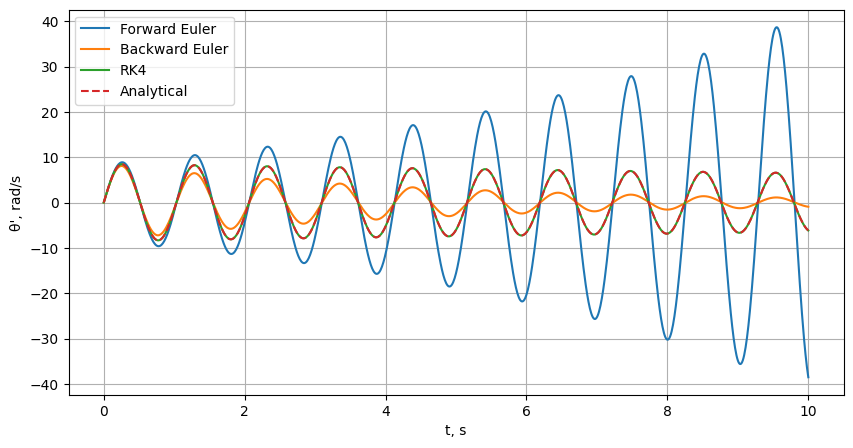

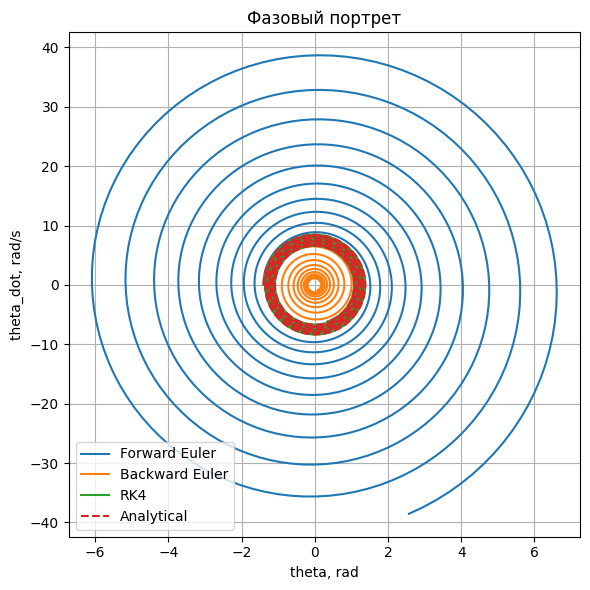

In [8]:
import numpy as np
import matplotlib.pyplot as plt

m = 0.8
l = 0.9
k = 17.0
b = 0.035
g = 9.81

I = m * l**2
K_eq = k + m * g * l

delta = b / (2 * I)
omega_d = np.sqrt(K_eq / I - delta**2)

print("I =", I)
print("K_eq =", K_eq)
print("delta =", delta)
print("omega_d =", omega_d)

theta0 = -1.398052152
omega0 = 0.0
x0 = np.array([theta0, omega0])


def ms_pendulum_dynamics_linear(x):
    theta, theta_dot = x
    theta_ddot = - (b / I) * theta_dot - (K_eq / I) * theta
    return np.array([theta_dot, theta_ddot])


def theta_analytic(t, theta0, omega0):
    C1 = theta0
    C2 = (omega0 + delta * theta0) / omega_d
    return np.exp(-delta * t) * (C1 * np.cos(omega_d * t) + C2 * np.sin(omega_d * t))


def theta_dot_analytic(t, theta0, omega0):
    C1 = theta0
    C2 = (omega0 + delta * theta0) / omega_d

    exp_term = np.exp(-delta * t)
    cos_term = np.cos(omega_d * t)
    sin_term = np.sin(omega_d * t)

    term1 = -delta * (C1 * cos_term + C2 * sin_term)
    term2 = -C1 * omega_d * sin_term + C2 * omega_d * cos_term

    return exp_term * (term1 + term2)


def forward_euler(fun, x0, Tf, h):
    """
    Явный метод Эйлера.
    fun(x) -> dx/dt
    """
    t = np.arange(0, Tf + h, h)
    x_hist = np.zeros((len(x0), len(t)))
    x_hist[:, 0] = x0

    for k in range(len(t) - 1):
        x_hist[:, k + 1] = x_hist[:, k] + h * fun(x_hist[:, k])

    return x_hist, t


def backward_euler(fun, x0, Tf, h, tol=1e-8, max_iter=100):
    """
    Неявный метод Эйлера (фикс-поинт итерации).
    """
    t = np.arange(0, Tf + h, h)
    x_hist = np.zeros((len(x0), len(t)))
    x_hist[:, 0] = x0

    for k in range(len(t) - 1):
        x_hist[:, k + 1] = x_hist[:, k]

        for _ in range(max_iter):
            x_next = x_hist[:, k] + h * fun(x_hist[:, k + 1])
            error = np.linalg.norm(x_next - x_hist[:, k + 1])
            x_hist[:, k + 1] = x_next
            if error < tol:
                break

    return x_hist, t


def runge_kutta4(fun, x0, Tf, h):
    """
    Метод Рунге–Кутта 4-го порядка.
    """
    t = np.arange(0, Tf + h, h)
    x_hist = np.zeros((len(x0), len(t)))
    x_hist[:, 0] = x0

    for k in range(len(t) - 1):
        k1 = fun(x_hist[:, k])
        k2 = fun(x_hist[:, k] + 0.5 * h * k1)
        k3 = fun(x_hist[:, k] + 0.5 * h * k2)
        k4 = fun(x_hist[:, k] + h * k3)

        x_hist[:, k + 1] = x_hist[:, k] + (h / 6.0) * (k1 + 2*k2 + 2*k3 + k4)

    return x_hist, t


Tf = 10.0     # Время моделирования, сек
h = 0.01      # шаг интегрирования

x_fe, t = forward_euler(ms_pendulum_dynamics_linear, x0, Tf, h)
x_be, _ = backward_euler(ms_pendulum_dynamics_linear, x0, Tf, h)
x_rk4, _ = runge_kutta4(ms_pendulum_dynamics_linear, x0, Tf, h)

theta_a = theta_analytic(t, theta0, omega0)
theta_dot_a = theta_dot_analytic(t, theta0, omega0)


def max_error(num, ana):
    return np.max(np.abs(num - ana))


def l2_error(num, ana, h):
    """
    L2-норма ошибки: sqrt( sum (e_i^2) * h )
    """
    e = num - ana
    return np.sqrt(np.sum(e**2) * h)


print("\n=== Ошибки по углу theta(t) ===")
print("Forward Euler:  max =", max_error(x_fe[0, :], theta_a),
      ", L2 =", l2_error(x_fe[0, :], theta_a, h))
print("Backward Euler: max =", max_error(x_be[0, :], theta_a),
      ", L2 =", l2_error(x_be[0, :], theta_a, h))
print("RK4:            max =", max_error(x_rk4[0, :], theta_a),
      ", L2 =", l2_error(x_rk4[0, :], theta_a, h))

print("\n=== Ошибки по скорости theta_dot(t) ===")
print("Forward Euler:  max =", max_error(x_fe[1, :], theta_dot_a),
      ", L2 =", l2_error(x_fe[1, :], theta_dot_a, h))
print("Backward Euler: max =", max_error(x_be[1, :], theta_dot_a),
      ", L2 =", l2_error(x_be[1, :], theta_dot_a, h))
print("RK4:            max =", max_error(x_rk4[1, :], theta_dot_a),
      ", L2 =", l2_error(x_rk4[1, :], theta_dot_a, h))


plt.figure(figsize=(10, 5))
plt.plot(t, x_fe[0, :], label='Forward Euler')
plt.plot(t, x_be[0, :], label='Backward Euler')
plt.plot(t, x_rk4[0, :], label='RK4')
plt.plot(t, theta_a, '--', label='Analytical')
plt.xlabel("t, s")
plt.ylabel("θ(t), rad")
plt.grid(True)
plt.legend()

plt.figure(figsize=(10, 5))
plt.plot(t, x_fe[1, :], label='Forward Euler')
plt.plot(t, x_be[1, :], label='Backward Euler')
plt.plot(t, x_rk4[1, :], label='RK4')
plt.plot(t, theta_dot_a, '--', label='Analytical')
plt.xlabel("t, s")
plt.ylabel("θ', rad/s")
plt.grid(True)
plt.legend()

plt.figure(figsize=(6, 6))
plt.plot(x_fe[0, :], x_fe[1, :], label='Forward Euler')
plt.plot(x_be[0, :], x_be[1, :], label='Backward Euler')
plt.plot(x_rk4[0, :], x_rk4[1, :], label='RK4')
plt.plot(theta_a, theta_dot_a, '--', label='Analytical')
plt.xlabel("theta, rad")
plt.ylabel("theta_dot, rad/s")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()